In [1]:
import fitz  # PyMuPDF
import os
import re
from sentence_transformers import SentenceTransformer
import chromadb
from langchain.text_splitter import RecursiveCharacterTextSplitter
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [2]:
embedding_model = None
chroma_client = None
collection = None

In [3]:
def load_embedding_model():
    """Load the sentence transformer model for embeddings"""
    global embedding_model
    print("Loading embedding model (BAAI/bge-base-en-v1.5)...")
    print("This may take a moment on first run...")

    # CHANGE: Use a better embedding model
    embedding_model = SentenceTransformer('BAAI/bge-base-en-v1.5')
    # Alternative options:
    # embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    # embedding_model = SentenceTransformer('intfloat/e5-base-v2')

    print("Embedding model loaded successfully!")
    return embedding_model


def initialize_database(db_path="./vector_july22"):
    """Initialize ChromaDB and create/get collection"""
    global chroma_client, collection

    print("Initializing ChromaDB...")
    chroma_client = chromadb.PersistentClient(path="vector_july22")
    collection = chroma_client.get_or_create_collection(
        name="rag-chunks",
        metadata={"hnsw:space": "cosine"}  # Better for semantic similarity
    )
    print("Persistent ChromaDB initialized with collection 'rag-chunks'")

    return collection
load_embedding_model()
initialize_database()


Loading embedding model (BAAI/bge-base-en-v1.5)...
This may take a moment on first run...
Embedding model loaded successfully!
Initializing ChromaDB...
Persistent ChromaDB initialized with collection 'rag-chunks'


Collection(name=rag-chunks)

In [4]:
def extract_text_generic_smart(pdf_path, skip_first_pages=None):
    print(f" Processing: {os.path.basename(pdf_path)}")
    
    doc = None
    try:
        doc = fitz.open(pdf_path)
        total_pages = doc.page_count
        
        # Use smart detection if not specified
        if skip_first_pages is None:
            skip_first_pages = 7  
            for page_num in range(5, min(20, total_pages)):
                page = doc[page_num]
                text = page.get_text().lower()
                
                if re.search(r'(chapter\s+1|^1\.\s*introduction|^1\.1\s+|^introduction$)', text, re.MULTILINE):
                    skip_first_pages = page_num
                    print(f"Found content start marker at page {page_num + 1}")
                    break
        
        print(f" Total pages: {total_pages}")
        print(f"⏭  Skipping first {skip_first_pages} pages")
        start_page = skip_first_pages
        pages_to_process = total_pages - start_page
        
        print(f"Processing pages {start_page + 1} to {total_pages} ({pages_to_process} pages)")
        
        raw_text = ""
        page_texts = []
        structured_content = []
        for page_num in range(start_page, total_pages):
            try:
                page = doc[page_num]

                blocks = page.get_text("dict")
                page_structured_text = []
                current_paragraph = []
                
                for block in blocks["blocks"]:
                    if "lines" in block:
                        for line in block["lines"]:
                            if line["spans"]:
                                text = " ".join([span["text"] for span in line["spans"]])
                                font_size = line["spans"][0]["size"] if line["spans"] else 12
                                if (font_size > 14 or not text.strip()) and current_paragraph:
                                    combined_text = " ".join(current_paragraph)
                                    if combined_text.strip():
                                        page_structured_text.append({
                                            "text": combined_text.strip(),
                                            "is_heading": False,
                                            "font_size": 12,
                                            "page": page_num + 1
                                        })
                                    current_paragraph = []
                                if font_size > 14:
                                    page_structured_text.append({
                                        "text": text.strip(),
                                        "is_heading": True,
                                        "font_size": font_size,
                                        "page": page_num + 1
                                    })
                                elif text.strip():
                                    current_paragraph.append(text.strip())
                if current_paragraph:
                    combined_text = " ".join(current_paragraph)
                    if combined_text.strip():
                        page_structured_text.append({
                            "text": combined_text.strip(),
                            "is_heading": False,
                            "font_size": 12,
                            "page": page_num + 1
                        })
                page_text = page.get_text()
                page_texts.append(page_text)
                structured_content.extend(page_structured_text)
                raw_text += page_text + '\n'
                
            except Exception as e:
                print(f"Could not read page {page_num + 1}: {e}")
                continue
        
        if not raw_text.strip():
            print("No text found")
            return None
        
        print(f"Extracted text from {len(page_texts)} pages")
        print(f"Total text length: {len(raw_text)} characters")
        cleaned_text = remove_headers_footers_generic(page_texts)
        doc.structured_content = structured_content    
        return cleaned_text    
    except Exception as e:
        print(f"Error: {e}")
        return None
    
    finally:
        if doc:
            try:
                doc.close()
            except:
                pass
def remove_headers_footers_generic(page_texts):
    """Remove headers and footers based on position and repetition"""
    print("Removing headers and footers generically...")
    
    if not page_texts:
        return ""
    
    # Split each page into lines
    all_page_lines = []
    for page_text in page_texts:
        lines = [line.strip() for line in page_text.split('\n') if line.strip()]
        all_page_lines.append(lines)
    
    # Find common headers (first few lines that repeat across pages)
    header_lines = find_common_position_lines(all_page_lines, position='top', max_lines=3)
    
    # Find common footers (last few lines that repeat across pages)
    footer_lines = find_common_position_lines(all_page_lines, position='bottom', max_lines=3)
    
    print(f"   Found {len(header_lines)} common header patterns")
    print(f"   Found {len(footer_lines)} common footer patterns")
    
    # Remove headers and footers from all pages
    cleaned_pages = []
    for page_lines in all_page_lines:
        # Remove headers (from top)
        start_idx = 0
        for line in page_lines[:5]:  # Check first 5 lines
            if line in header_lines:
                start_idx += 1
            else:
                break
        
        # Remove footers (from bottom)
        end_idx = len(page_lines)
        for line in reversed(page_lines[-5:]):  # Check last 5 lines
            if line in footer_lines:
                end_idx -= 1
            else:
                break
        
        # Keep the middle content
        clean_lines = page_lines[start_idx:end_idx]
        if clean_lines:
            cleaned_pages.append('\n'.join(clean_lines))
    
    final_text = '\n\n'.join(cleaned_pages)
    
    # Basic cleanup
    final_text = re.sub(r'\n\s*\n\s*\n+', '\n\n', final_text)
    final_text = re.sub(r'[ \t]+', ' ', final_text)
    
    return final_text.strip()

def find_common_position_lines(all_page_lines, position='top', max_lines=3):
    """Find lines that commonly appear at top or bottom of pages"""
    if len(all_page_lines) < 2:
        return set()
    
    # Count how often each line appears in the same position
    line_counts = {}
    
    for page_lines in all_page_lines:
        if not page_lines:
            continue
            
        # Get lines from specified position
        if position == 'top':
            check_lines = page_lines[:max_lines]
        else:  # bottom
            check_lines = page_lines[-max_lines:]
        
        for line in check_lines:
            if len(line) > 5:  # Ignore very short lines
                line_counts[line] = line_counts.get(line, 0) + 1
    
    # Find lines that appear in at least 50% of pages
    total_pages = len(all_page_lines)
    threshold = max(2, total_pages * 0.5)
    
    common_lines = set()
    for line, count in line_counts.items():
        if count >= threshold:
            common_lines.add(line)
    
    return common_lines

In [5]:
def extract_text_adaptive(pdf_path):
    return extract_text_generic_smart(pdf_path)

In [6]:
def evaluate_chunk_quality(chunk):
    if len(chunk) < 100:
        return 0
    
    score = 0
    
    # 1. Length score - prefer longer chunks
    length_score = min(len(chunk) / 1500, 1.0)
    score += length_score * 0.4
    
    # 2. Word count
    words = chunk.split()
    if len(words) > 50:
        score += 0.3
    
    # 3. Sentence structure
    sentences = re.split(r'[.!?]+', chunk)
    complete_sentences = [s for s in sentences if len(s.strip()) > 10]
    if len(complete_sentences) >= 2:
        score += 0.2
    
    # 4. Alphabetic content ratio
    alpha_ratio = sum(c.isalpha() or c.isspace() for c in chunk) / len(chunk)
    score += alpha_ratio * 0.1
    
    return score

def quality_based_chunking(text, chunk_size=2000, chunk_overlap=500, min_quality=0.3):
    """Create LARGER chunks with better size guarantees"""
    print(f"Creating quality chunks (size: {chunk_size})...")
    
    # Use standard chunking with good separators
    from langchain.text_splitter import RecursiveCharacterTextSplitter
    
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n\n", "\n\n", ".\n\n", ".\n", ". ", "\n", " "],
        length_function=len,
    )
    
    initial_chunks = splitter.split_text(text)
    
    # Combine small consecutive chunks
    combined_chunks = []
    current_chunk = ""
    
    for chunk in initial_chunks:
        # If current chunk + new chunk is still under 1.5x chunk_size, combine them
        if len(current_chunk) + len(chunk) < chunk_size * 1.5:
            if current_chunk:
                current_chunk += "\n\n" + chunk
            else:
                current_chunk = chunk
        else:
            # Save current chunk if it's big enough
            if current_chunk and len(current_chunk) > 500:
                combined_chunks.append(current_chunk)
            current_chunk = chunk
    
    # Don't forget the last chunk
    if current_chunk and len(current_chunk) > 500:
        combined_chunks.append(current_chunk)
    
    print(f"   Combined {len(initial_chunks)} initial chunks into {len(combined_chunks)} chunks")
    
    # Filter by quality but be less aggressive
    quality_chunks = []
    low_quality_chunks = []
    quality_scores = []
    
    for chunk in combined_chunks:
        chunk = chunk.strip()
        quality = evaluate_chunk_quality(chunk)
        
        if quality >= min_quality or len(chunk) > 1000:  # Keep chunks > 1000 chars regardless
            quality_chunks.append(chunk)
            quality_scores.append(quality)
        else:
            low_quality_chunks.append(chunk)
    
    # Try to salvage low quality chunks by combining them
    if low_quality_chunks:
        combined_low = " ".join(low_quality_chunks)
        if len(combined_low) > 1000:
            quality_chunks.append(combined_low)
            quality_scores.append(0.5)
    
    avg_quality = sum(quality_scores) / len(quality_scores) if quality_scores else 0
    
    print(f"Created {len(quality_chunks)} quality chunks")
    print(f"   Average quality score: {avg_quality:.2f}")
    if quality_chunks:
        avg_len = sum(len(c) for c in quality_chunks) / len(quality_chunks)
        print(f"   Average chunk length: {avg_len:.0f} chars")
        print(f"   Min chunk length: {min(len(c) for c in quality_chunks)} chars")
        print(f"   Max chunk length: {max(len(c) for c in quality_chunks)} chars")
    
    return quality_chunks

In [7]:
def generate_embeddings(chunks):
    """Generate embeddings for text chunks"""
    print(f"Generating embeddings for {len(chunks)} chunks...")
    
    # CHANGE: Add normalize_embeddings parameter
    embeddings = embedding_model.encode(
        chunks, 
        show_progress_bar=True,
        normalize_embeddings=True  # This ensures cosine similarity works better
    )
    
    print(f"Generated embeddings with shape: {embeddings.shape}")
    return embeddings
def extract_metadata_from_chunk(chunk, chunk_id, pdf_name):
    """Extract metadata from chunk content"""
    metadata = {
        "source": pdf_name,
        "chunk_id": chunk_id,
        "chunk_length": len(chunk),
        "word_count": len(chunk.split())
    }
    
    # Try to extract chapter info
    chapter_match = re.search(r'CHAPTER\s+(\d+)|Chapter\s+(\d+)', chunk)
    if chapter_match:
        metadata["chapter"] = chapter_match.group(1) or chapter_match.group(2)
    
    # Try to extract section info
    section_match = re.search(r'(\d+\.\d+)\s+', chunk)
    if section_match:
        metadata["section"] = section_match.group(1)
    
    # Extract potential title (first line if it's short and looks like a heading)
    first_line = chunk.split('\n')[0].strip()
    if len(first_line) < 100 and first_line.isupper():
        metadata["potential_title"] = first_line
    
    # Add preview
    metadata["preview"] = chunk[:200].replace('\n', ' ')
    
    return metadata

def store_chunks_in_db(chunks, embeddings, pdf_name):
    """Store chunks and embeddings in the vector database with rich metadata"""
    print(f"Storing {len(chunks)} chunks in vector database...")
    
    # Prepare data for storage
    ids = [f"{pdf_name}_chunk_{i}" for i in range(len(chunks))]
    metadatas = []
    
    for i, chunk in enumerate(chunks):
        metadata = extract_metadata_from_chunk(chunk, i, pdf_name)
        metadata["total_chunks"] = len(chunks)
        metadata["position_ratio"] = i / len(chunks)  # How far into doc
        metadatas.append(metadata)
    
    # Add to collection
    collection.add(
        embeddings=embeddings.tolist(),
        documents=chunks,
        metadatas=metadatas,
        ids=ids
    )
    
    print(f"Successfully stored {len(chunks)} chunks from {pdf_name}")
    print(f"Chapters found: {len(set(m.get('chapter', 'none') for m in metadatas))}")
    print(f"Sections found: {len(set(m.get('section', 'none') for m in metadatas))}")
    
    return len(chunks)

In [8]:
def process_single_pdf(pdf_path):
    """Process a single PDF file with duplicate checking"""
    pdf_name = os.path.basename(pdf_path)
    print(f"\n{'='*60}")
    print(f"Processing: {pdf_name}")
    print(f"{'='*60}")
    
    # Check if already processed
    try:
        existing = collection.get(where={"source": pdf_name})
        if existing['ids']:
            print(f" {pdf_name} already in database with {len(existing['ids'])} chunks")
            response = input("Re-process? (yes/no): ")
            if response.lower() != 'yes':
                return 0
            else:
                # Delete existing chunks
                collection.delete(ids=existing['ids'])
                print(f"Deleted {len(existing['ids'])} existing chunks")
    except:
        pass
    
    try:
        # Step 1: Extract and clean text
        text = extract_text_adaptive(pdf_path)
        if not text:
            print(f"Failed to extract meaningful text from {pdf_name}")
            return 0
        
        print(f" Extracted text length: {len(text)} characters")
        
        # Step 2: Quality-based chunking with new parameters
        chunks = quality_based_chunking(text, chunk_size=2000, chunk_overlap=500, min_quality=0.3)
        if not chunks:
            print(f" No quality chunks created from {pdf_name}")
            return 0
        
        # Step 3: Generate embeddings
        embeddings = generate_embeddings(chunks)
        
        # Step 4: Store in database
        chunk_count = store_chunks_in_db(chunks, embeddings, pdf_name)
        
        print(f" Successfully processed {pdf_name}!")
        return chunk_count
    
    except Exception as e:
        print(f"Error processing {pdf_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        return 0
def list_available_pdfs(folder_path="./pdfs"):
    """List all PDF files in the folder with details"""
    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} does not exist!")
        return []
    
    pdf_files = [f for f in os.listdir(folder_path) if f.endswith('.pdf')]
    
    print(f" PDFs found in {folder_path}:")
    if pdf_files:
        for i, pdf in enumerate(pdf_files, 1):
            
            file_path = os.path.join(folder_path, pdf)
            file_size = os.path.getsize(file_path) / (1024*1024)  # MB
            print(f"  {i}. {pdf} ({file_size:.1f} MB)")
    else:
        print("  No PDF files found!")
        print(f" Please add your PDF files to the '{folder_path}' folder")
    
    return pdf_files

def process_all_pdfs(folder_path="./pdfs"):
    """Process all PDF files in the folder with adaptive cleaning"""
    pdf_files = list_available_pdfs(folder_path)
    
    if not pdf_files:
        print("No PDF files to process!")
        return [], 0
    
    print(f"\nStarting to process {len(pdf_files)} PDF files...")
    print("Using adaptive cleaning and quality-based chunking...")
    
    total_chunks = 0
    processed_files = []
    
    for pdf_file in pdf_files:
        pdf_path = os.path.join(folder_path, pdf_file)
        chunk_count = process_single_pdf(pdf_path)
        
        if chunk_count > 0:
            processed_files.append((pdf_file, chunk_count))
            total_chunks += chunk_count
    
    # Summary
    print(f"\n{'='*70}")
    print(f" PROCESSING COMPLETE!")
    print(f"{'='*70}")
    print(f"Files processed: {len(processed_files)}/{len(pdf_files)}")
    print(f"Total chunks stored: {total_chunks}")
    print("\nSummary:")
    for filename, chunk_count in processed_files:
        print(f"{filename}: {chunk_count} chunks")
    
    return processed_files, total_chunks

In [9]:
# Add this import at the top of the cell
from sentence_transformers import CrossEncoder

# Initialize reranker globally
reranker = None

def initialize_reranker():
    global reranker
    reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
    return reranker

def search_similar_chunks(query, n_results=5, filter_dict=None, min_relevance=0.5):
    print(f"🔍 Searching for: '{query}'")
    
    try:
        # Generate embedding for query with normalization
        query_embedding = embedding_model.encode([query], normalize_embeddings=True)
        
        # Get more candidates for reranking (3x the requested amount)
        search_params = {
            "query_embeddings": query_embedding.tolist(),
            "n_results": min(n_results * 4, 40)  # Get up to 40 candidates
        }
        
        if filter_dict:
            search_params["where"] = filter_dict
            print(f"   With filters: {filter_dict}")
        
        # Search in collection
        results = collection.query(**search_params)
        
        if not results['documents'][0]:
            print("No results found")
            return []
        
        # Prepare candidates for reranking
        candidates = []
        for i, doc in enumerate(results['documents'][0]):
            candidates.append({
                'document': doc,
                'metadata': results['metadatas'][0][i],
                'initial_score': 1 - results['distances'][0][i],
                'id': results['ids'][0][i]
            })
        
        # Initialize reranker if not already done
        global reranker
        if reranker is None:
            initialize_reranker()
        
        # Rerank using cross-encoder
        print(f"Reranking {len(candidates)} candidates...")
        pairs = [[query, c['document'][:512]] for c in candidates]  # Limit text for reranker
        rerank_scores = reranker.predict(pairs)
        
        # Combine scores and filter
        final_results = []
        for i, candidate in enumerate(candidates):
            # Combine initial embedding score with rerank score
            combined_score = (candidate['initial_score'] * 0.3) + (rerank_scores[i] * 0.7)
            
            if combined_score >= min_relevance:
                candidate['rerank_score'] = rerank_scores[i]
                candidate['final_score'] = combined_score
                final_results.append(candidate)
        
        # Sort by final score
        final_results.sort(key=lambda x: x['final_score'], reverse=True)
        top_results = final_results[:n_results]
        
        if not top_results:
            print(f"No results above relevance threshold {min_relevance}")
            return []
        
        print(f" Found {len(candidates)} candidates, {len(final_results)} above threshold, returning top {len(top_results)}:")
        
        for i, result in enumerate(top_results):
            metadata = result['metadata']
            print(f"\n{i+1}. {metadata['source']} (ID: {result['id'][-8:]})") 
            if metadata.get('chapter'):
                print(f" Chapter {metadata['chapter']}")
            if metadata.get('section'):
                print(f"  Section {metadata['section']}")
            print(f"   Initial: {result['initial_score']:.3f}, Rerank: {result['rerank_score']:.3f}, Final: {result['final_score']:.3f}")
            print(f"   Chunk size: {len(result['document'])} chars")
            print(f"   Preview: {result['document'][:200]}...")
        
        return top_results
    
    except Exception as e:
        print(f" Search failed: {e}")
        import traceback
        traceback.print_exc()
        return []

# Update build_context_for_chatbot to handle no results better
def build_context_for_chatbot(query, n_chunks=3, min_relevance=0.5):
    """Build context for chatbot from search results"""
    results = search_similar_chunks(query, n_chunks, min_relevance=min_relevance)
    
    if not results:
        return "I couldn't find sufficiently relevant information in the documents to answer your question. Please try rephrasing your query or ask about topics covered in the uploaded documents."
    
    # Only use results with high confidence
    high_confidence_results = [r for r in results if r['final_score'] >= 0.7]
    
    if high_confidence_results:
        context = "Based on the following highly relevant information from the documents:\n\n"
    else:
        context = "Based on the following potentially relevant information from the documents (moderate confidence):\n\n"
    
    for i, result in enumerate(results):
        metadata = result['metadata']
        context += f"[Source {i+1}: {metadata['source']}"
        
        if metadata.get('chapter'):
            context += f", Chapter {metadata['chapter']}"
        if metadata.get('section'):
            context += f", Section {metadata['section']}"
        
        context += f" - Relevance: {result['final_score']:.2f}]\n"
        context += f"{result['document']}\n\n"
        context += "-" * 50 + "\n\n"
    
    return context

def get_database_stats():
    """Get comprehensive database statistics"""
    try:
        count = collection.count()
        print(f"Database Statistics:")
        print(f" Total chunks stored: {count}")
        
        if count > 0:
            # Get sample to analyze
            sample = collection.get(limit=min(count, 1000))
            
            # Count chunks per document
            source_counts = {}
            chapter_counts = {}
            
            for meta in sample['metadatas']:
                source = meta['source']
                source_counts[source] = source_counts.get(source, 0) + 1
                
                if meta.get('chapter'):
                    chapter_key = f"{source} - Chapter {meta['chapter']}"
                    chapter_counts[chapter_key] = chapter_counts.get(chapter_key, 0) + 1
            
            print(f"  Documents stored: {len(source_counts)}")
            print(f"   Chapters identified: {len(chapter_counts)}")
            print(f"\n  Chunks per document:")
            for source, chunk_count in source_counts.items():
                print(f"     • {source}: {chunk_count} chunks")
        
        return count
    
    except Exception as e:
        print(f"Error getting database stats: {e}")
        return 0



def show_sample_chunks(n_samples=3):
    """Show sample chunks from the database"""
    try:
        sample = collection.peek(limit=n_samples)
        print(f"Sample chunks (showing {n_samples}):")
        
        for i, doc in enumerate(sample['documents']):
            metadata = sample['metadatas'][i]
            print(f"\n{i+1}. {metadata['source']} (Chunk {metadata['chunk_id']})")
            if metadata.get('chapter'):
                print(f"   Chapter {metadata['chapter']}")
            if metadata.get('section'):
                print(f"   Section {metadata['section']}")
            print(f"   Content: {doc[:200]}...")
    
    except Exception as e:
        print(f" Error showing samples: {e}")

def answer_question(question, n_chunks=3, verbose=False):
    """
    Simple Q&A function for chatbot integration
    """
    if verbose:
        print(f"Question: {question}")
    
    # Get context
    context = build_context_for_chatbot(question, n_chunks)
    
    # Format for LLM
    prompt = f"""Based on the following context from technical documents, please answer the question.
    
Context:
{context}

Question: {question}

Answer: """
    
    if verbose:
        print(f"\n Context has {len(context.split())} words")
    
    return prompt


# Keep the other utility functions as they are

In [10]:
import os

# Change working directory to the notebook location
os.chdir(os.path.dirname(os.path.abspath("__file__")))


In [11]:
print("PDFs:", list_available_pdfs("./pdfs"))


 PDFs found in ./pdfs:
  1. 100_Report - Raj Kiran.pdf (1.2 MB)
  2. 101_Report - Deepti M P.pdf (1.5 MB)
  3. 102_Report - Navaneeth krishnan R.pdf (1.1 MB)
  4. 103_Report - TADISETTY SAI YASHWANTH 2022 Batch PES University EC.pdf (1.7 MB)
  5. 104_Report - Rahul28 Carasala.pdf (0.8 MB)
  6. 105_Report - Mayadevi Poojari.pdf (3.9 MB)
  7. 106_Report - Navya Pai.pdf (1.2 MB)
  8. 107_Report - SARANGA A KULKARNI 2022 Batch PES University EC.pdf (1.7 MB)
  9. 108_Report - dharini hindlatti.pdf (0.9 MB)
  10. 109_Report - Chandra Priya.pdf (0.8 MB)
  11. 110_Report - Vansheel Desai.pdf (1.1 MB)
  12. 111_REPORT - Srujan Vr.pdf (1.9 MB)
  13. 112_Report - Ashwin Sridhar.pdf (1.2 MB)
  14. 113_Report - Sujal S.pdf (1.5 MB)
  15. 114_Report - Aditya S Joshi.pdf (1.7 MB)
  16. 115_Report - SHRUTI C.pdf (2.1 MB)
  17. 116_Report - rhea sheth.pdf (3.1 MB)
  18. 117_Report - Pratham Shetty.pdf (1.0 MB)
  19. 118_Report - MOHAMMED BASIM ALSM 2022 Batch PES University EC.pdf (1.1 MB)
  20. 119_Re

In [12]:
## Cell 10: Execute Processing

# Check what PDFs are available
print("Checking available PDFs...")
pdf_files = list_available_pdfs("./pdfs")

# Process all PDFs if any are found
if pdf_files:
    print(f"\n Starting processing of {len(pdf_files)} PDF files...")
    processed_files, total_chunks = process_all_pdfs("./pdfs")
else:
    print("\nTo get started:")
    print("1. Add your PDF files to the './pdfs' folder")
    print("2. Rerun this cell to process them")


Checking available PDFs...
 PDFs found in ./pdfs:
  1. 100_Report - Raj Kiran.pdf (1.2 MB)
  2. 101_Report - Deepti M P.pdf (1.5 MB)
  3. 102_Report - Navaneeth krishnan R.pdf (1.1 MB)
  4. 103_Report - TADISETTY SAI YASHWANTH 2022 Batch PES University EC.pdf (1.7 MB)
  5. 104_Report - Rahul28 Carasala.pdf (0.8 MB)
  6. 105_Report - Mayadevi Poojari.pdf (3.9 MB)
  7. 106_Report - Navya Pai.pdf (1.2 MB)
  8. 107_Report - SARANGA A KULKARNI 2022 Batch PES University EC.pdf (1.7 MB)
  9. 108_Report - dharini hindlatti.pdf (0.9 MB)
  10. 109_Report - Chandra Priya.pdf (0.8 MB)
  11. 110_Report - Vansheel Desai.pdf (1.1 MB)
  12. 111_REPORT - Srujan Vr.pdf (1.9 MB)
  13. 112_Report - Ashwin Sridhar.pdf (1.2 MB)
  14. 113_Report - Sujal S.pdf (1.5 MB)
  15. 114_Report - Aditya S Joshi.pdf (1.7 MB)
  16. 115_Report - SHRUTI C.pdf (2.1 MB)
  17. 116_Report - rhea sheth.pdf (3.1 MB)
  18. 117_Report - Pratham Shetty.pdf (1.0 MB)
  19. 118_Report - MOHAMMED BASIM ALSM 2022 Batch PES University E

 100_Report - Raj Kiran.pdf already in database with 23 chunks

Processing: 101_Report - Deepti M P.pdf
 101_Report - Deepti M P.pdf already in database with 31 chunks

Processing: 102_Report - Navaneeth krishnan R.pdf
 102_Report - Navaneeth krishnan R.pdf already in database with 30 chunks

Processing: 103_Report - TADISETTY SAI YASHWANTH 2022 Batch PES University EC.pdf
 103_Report - TADISETTY SAI YASHWANTH 2022 Batch PES University EC.pdf already in database with 27 chunks
Deleted 27 existing chunks
 Processing: 103_Report - TADISETTY SAI YASHWANTH 2022 Batch PES University EC.pdf
Found content start marker at page 7
 Total pages: 44
⏭  Skipping first 6 pages
Processing pages 7 to 44 (38 pages)
Extracted text from 38 pages
Total text length: 55180 characters
Removing headers and footers generically...
   Found 2 common header patterns
   Found 2 common footer patterns
 Extracted text length: 52153 characters
Creating quality chunks (size: 2000)...
   Combined 34 initial chunks into

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (27, 768)
Storing 27 chunks in vector database...
Successfully stored 27 chunks from 103_Report - TADISETTY SAI YASHWANTH 2022 Batch PES University EC.pdf
Chapters found: 9
Sections found: 14
 Successfully processed 103_Report - TADISETTY SAI YASHWANTH 2022 Batch PES University EC.pdf!

Processing: 104_Report - Rahul28 Carasala.pdf
 104_Report - Rahul28 Carasala.pdf already in database with 28 chunks
Deleted 28 existing chunks
 Processing: 104_Report - Rahul28 Carasala.pdf
Found content start marker at page 6
 Total pages: 40
⏭  Skipping first 5 pages
Processing pages 6 to 40 (35 pages)
Extracted text from 35 pages
Total text length: 59797 characters
Removing headers and footers generically...
   Found 3 common header patterns
   Found 0 common footer patterns
 Extracted text length: 55618 characters
Creating quality chunks (size: 2000)...
   Combined 45 initial chunks into 28 chunks
Created 28 quality chunks
   Average quality score: 0.99
   Average ch

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (28, 768)
Storing 28 chunks in vector database...
Successfully stored 28 chunks from 104_Report - Rahul28 Carasala.pdf
Chapters found: 1
Sections found: 5
 Successfully processed 104_Report - Rahul28 Carasala.pdf!

Processing: 105_Report - Mayadevi Poojari.pdf
 105_Report - Mayadevi Poojari.pdf already in database with 17 chunks
Deleted 17 existing chunks
 Processing: 105_Report - Mayadevi Poojari.pdf
Found content start marker at page 6
 Total pages: 50
⏭  Skipping first 5 pages
Processing pages 6 to 50 (45 pages)
Extracted text from 45 pages
Total text length: 51139 characters
Removing headers and footers generically...
   Found 3 common header patterns
   Found 0 common footer patterns
 Extracted text length: 33440 characters
Creating quality chunks (size: 2000)...
   Combined 25 initial chunks into 17 chunks
Created 17 quality chunks
   Average quality score: 0.99
   Average chunk length: 2108 chars
   Min chunk length: 1303 chars
   Max chunk lengt

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (17, 768)
Storing 17 chunks in vector database...
Successfully stored 17 chunks from 105_Report - Mayadevi Poojari.pdf
Chapters found: 8
Sections found: 3
 Successfully processed 105_Report - Mayadevi Poojari.pdf!

Processing: 106_Report - Navya Pai.pdf
 106_Report - Navya Pai.pdf already in database with 19 chunks
Deleted 19 existing chunks
 Processing: 106_Report - Navya Pai.pdf
Found content start marker at page 6
 Total pages: 48
⏭  Skipping first 5 pages
Processing pages 6 to 48 (43 pages)
Extracted text from 43 pages
Total text length: 50857 characters
Removing headers and footers generically...
   Found 2 common header patterns
   Found 0 common footer patterns
 Extracted text length: 39117 characters
Creating quality chunks (size: 2000)...
   Combined 28 initial chunks into 19 chunks
Created 19 quality chunks
   Average quality score: 0.98
   Average chunk length: 2113 chars
   Min chunk length: 1146 chars
   Max chunk length: 2969 chars
Generat

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (19, 768)
Storing 19 chunks in vector database...
Successfully stored 19 chunks from 106_Report - Navya Pai.pdf
Chapters found: 8
Sections found: 13
 Successfully processed 106_Report - Navya Pai.pdf!

Processing: 107_Report - SARANGA A KULKARNI 2022 Batch PES University EC.pdf
 107_Report - SARANGA A KULKARNI 2022 Batch PES University EC.pdf already in database with 25 chunks
Deleted 25 existing chunks
 Processing: 107_Report - SARANGA A KULKARNI 2022 Batch PES University EC.pdf
Found content start marker at page 6
 Total pages: 62
⏭  Skipping first 5 pages
Processing pages 6 to 62 (57 pages)
Extracted text from 57 pages
Total text length: 63445 characters
Removing headers and footers generically...
   Found 2 common header patterns
   Found 0 common footer patterns
 Extracted text length: 49424 characters
Creating quality chunks (size: 2000)...
   Combined 35 initial chunks into 25 chunks
Created 25 quality chunks
   Average quality score: 0.99
   Ave

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (25, 768)
Storing 25 chunks in vector database...
Successfully stored 25 chunks from 107_Report - SARANGA A KULKARNI 2022 Batch PES University EC.pdf
Chapters found: 8
Sections found: 19
 Successfully processed 107_Report - SARANGA A KULKARNI 2022 Batch PES University EC.pdf!

Processing: 108_Report - dharini hindlatti.pdf
 108_Report - dharini hindlatti.pdf already in database with 14 chunks
Deleted 14 existing chunks
 Processing: 108_Report - dharini hindlatti.pdf
Found content start marker at page 6
 Total pages: 42
⏭  Skipping first 5 pages
Processing pages 6 to 42 (37 pages)
Extracted text from 37 pages
Total text length: 32022 characters
Removing headers and footers generically...
   Found 0 common header patterns
   Found 0 common footer patterns
 Extracted text length: 30580 characters
Creating quality chunks (size: 2000)...
   Combined 21 initial chunks into 14 chunks
Created 14 quality chunks
   Average quality score: 0.99
   Average chunk len

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (14, 768)
Storing 14 chunks in vector database...
Successfully stored 14 chunks from 108_Report - dharini hindlatti.pdf
Chapters found: 1
Sections found: 11
 Successfully processed 108_Report - dharini hindlatti.pdf!

Processing: 109_Report - Chandra Priya.pdf
 109_Report - Chandra Priya.pdf already in database with 22 chunks
Deleted 22 existing chunks
 Processing: 109_Report - Chandra Priya.pdf
Found content start marker at page 6
 Total pages: 48
⏭  Skipping first 5 pages
Processing pages 6 to 48 (43 pages)
Extracted text from 43 pages
Total text length: 45668 characters
Removing headers and footers generically...
   Found 1 common header patterns
   Found 2 common footer patterns
 Extracted text length: 44118 characters
Creating quality chunks (size: 2000)...
   Combined 31 initial chunks into 22 chunks
Created 22 quality chunks
   Average quality score: 0.99
   Average chunk length: 2023 chars
   Min chunk length: 1337 chars
   Max chunk length: 281

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (22, 768)
Storing 22 chunks in vector database...
Successfully stored 22 chunks from 109_Report - Chandra Priya.pdf
Chapters found: 1
Sections found: 8
 Successfully processed 109_Report - Chandra Priya.pdf!

Processing: 110_Report - Vansheel Desai.pdf
 110_Report - Vansheel Desai.pdf already in database with 16 chunks
Deleted 16 existing chunks
 Processing: 110_Report - Vansheel Desai.pdf
Found content start marker at page 6
 Total pages: 44
⏭  Skipping first 5 pages
Processing pages 6 to 44 (39 pages)
Extracted text from 39 pages
Total text length: 38526 characters
Removing headers and footers generically...
   Found 0 common header patterns
   Found 0 common footer patterns
 Extracted text length: 36561 characters
Creating quality chunks (size: 2000)...
   Combined 28 initial chunks into 16 chunks
Created 16 quality chunks
   Average quality score: 0.99
   Average chunk length: 2294 chars
   Min chunk length: 1148 chars
   Max chunk length: 2962 char

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (16, 768)
Storing 16 chunks in vector database...
Successfully stored 16 chunks from 110_Report - Vansheel Desai.pdf
Chapters found: 1
Sections found: 11
 Successfully processed 110_Report - Vansheel Desai.pdf!

Processing: 111_REPORT - Srujan Vr.pdf
 111_REPORT - Srujan Vr.pdf already in database with 13 chunks
Deleted 13 existing chunks
 Processing: 111_REPORT - Srujan Vr.pdf
Found content start marker at page 6
 Total pages: 40
⏭  Skipping first 5 pages
Processing pages 6 to 40 (35 pages)
Extracted text from 35 pages
Total text length: 33416 characters
Removing headers and footers generically...
   Found 2 common header patterns
   Found 0 common footer patterns
 Extracted text length: 26780 characters
Creating quality chunks (size: 2000)...
   Combined 19 initial chunks into 13 chunks
Created 13 quality chunks
   Average quality score: 0.99
   Average chunk length: 2118 chars
   Min chunk length: 1493 chars
   Max chunk length: 2750 chars
Generating

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (13, 768)
Storing 13 chunks in vector database...
Successfully stored 13 chunks from 111_REPORT - Srujan Vr.pdf
Chapters found: 5
Sections found: 8
 Successfully processed 111_REPORT - Srujan Vr.pdf!

Processing: 112_Report - Ashwin Sridhar.pdf
 112_Report - Ashwin Sridhar.pdf already in database with 14 chunks
Deleted 14 existing chunks
 Processing: 112_Report - Ashwin Sridhar.pdf
Found content start marker at page 6
 Total pages: 44
⏭  Skipping first 5 pages
Processing pages 6 to 44 (39 pages)
Extracted text from 39 pages
Total text length: 36407 characters
Removing headers and footers generically...
   Found 0 common header patterns
   Found 0 common footer patterns
 Extracted text length: 26564 characters
Creating quality chunks (size: 2000)...
   Combined 19 initial chunks into 14 chunks
Created 14 quality chunks
   Average quality score: 0.99
   Average chunk length: 2026 chars
   Min chunk length: 1490 chars
   Max chunk length: 2973 chars
Genera

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (14, 768)
Storing 14 chunks in vector database...
Successfully stored 14 chunks from 112_Report - Ashwin Sridhar.pdf
Chapters found: 9
Sections found: 12
 Successfully processed 112_Report - Ashwin Sridhar.pdf!

Processing: 113_Report - Sujal S.pdf
 113_Report - Sujal S.pdf already in database with 37 chunks
Deleted 37 existing chunks
 Processing: 113_Report - Sujal S.pdf
Found content start marker at page 6
 Total pages: 62
⏭  Skipping first 5 pages
Processing pages 6 to 62 (57 pages)
Extracted text from 57 pages
Total text length: 78971 characters
Removing headers and footers generically...
   Found 2 common header patterns
   Found 0 common footer patterns
 Extracted text length: 72430 characters
Creating quality chunks (size: 2000)...
   Combined 51 initial chunks into 37 chunks
Created 37 quality chunks
   Average quality score: 0.99
   Average chunk length: 2032 chars
   Min chunk length: 1328 chars
   Max chunk length: 2895 chars
Generating embed

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Generated embeddings with shape: (37, 768)
Storing 37 chunks in vector database...
Successfully stored 37 chunks from 113_Report - Sujal S.pdf
Chapters found: 1
Sections found: 21
 Successfully processed 113_Report - Sujal S.pdf!

Processing: 114_Report - Aditya S Joshi.pdf
 114_Report - Aditya S Joshi.pdf already in database with 39 chunks

Processing: 115_Report - SHRUTI C.pdf
 115_Report - SHRUTI C.pdf already in database with 20 chunks
Deleted 20 existing chunks
 Processing: 115_Report - SHRUTI C.pdf
Found content start marker at page 6
 Total pages: 48
⏭  Skipping first 5 pages
Processing pages 6 to 48 (43 pages)
Extracted text from 43 pages
Total text length: 51846 characters
Removing headers and footers generically...
   Found 2 common header patterns
   Found 0 common footer patterns
 Extracted text length: 40001 characters
Creating quality chunks (size: 2000)...
   Combined 27 initial chunks into 20 chunks
Created 20 quality chunks
   Average quality score: 0.99
   Average chu

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (20, 768)
Storing 20 chunks in vector database...
Successfully stored 20 chunks from 115_Report - SHRUTI C.pdf
Chapters found: 8
Sections found: 11
 Successfully processed 115_Report - SHRUTI C.pdf!

Processing: 116_Report - rhea sheth.pdf
 116_Report - rhea sheth.pdf already in database with 20 chunks
Deleted 20 existing chunks
 Processing: 116_Report - rhea sheth.pdf
Found content start marker at page 6
 Total pages: 38
⏭  Skipping first 5 pages
Processing pages 6 to 38 (33 pages)
Extracted text from 33 pages
Total text length: 44392 characters
Removing headers and footers generically...
   Found 3 common header patterns
   Found 0 common footer patterns
 Extracted text length: 39001 characters
Creating quality chunks (size: 2000)...
   Combined 25 initial chunks into 20 chunks
Created 20 quality chunks
   Average quality score: 1.00
   Average chunk length: 1964 chars
   Min chunk length: 1578 chars
   Max chunk length: 2806 chars
Generating embeddin

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (20, 768)
Storing 20 chunks in vector database...
Successfully stored 20 chunks from 116_Report - rhea sheth.pdf
Chapters found: 8
Sections found: 17
 Successfully processed 116_Report - rhea sheth.pdf!

Processing: 117_Report - Pratham Shetty.pdf
 117_Report - Pratham Shetty.pdf already in database with 19 chunks
Deleted 19 existing chunks
 Processing: 117_Report - Pratham Shetty.pdf
Found content start marker at page 6
 Total pages: 40
⏭  Skipping first 5 pages
Processing pages 6 to 40 (35 pages)
Extracted text from 35 pages
Total text length: 43860 characters
Removing headers and footers generically...
   Found 2 common header patterns
   Found 0 common footer patterns
 Extracted text length: 37011 characters
Creating quality chunks (size: 2000)...
   Combined 25 initial chunks into 19 chunks
Created 19 quality chunks
   Average quality score: 0.98
   Average chunk length: 1977 chars
   Min chunk length: 1143 chars
   Max chunk length: 2916 chars
Gen

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (19, 768)
Storing 19 chunks in vector database...
Successfully stored 19 chunks from 117_Report - Pratham Shetty.pdf
Chapters found: 6
Sections found: 13
 Successfully processed 117_Report - Pratham Shetty.pdf!

Processing: 118_Report - MOHAMMED BASIM ALSM 2022 Batch PES University EC.pdf
 118_Report - MOHAMMED BASIM ALSM 2022 Batch PES University EC.pdf already in database with 14 chunks
Deleted 14 existing chunks
 Processing: 118_Report - MOHAMMED BASIM ALSM 2022 Batch PES University EC.pdf
Found content start marker at page 6
 Total pages: 40
⏭  Skipping first 5 pages
Processing pages 6 to 40 (35 pages)
Extracted text from 35 pages
Total text length: 37634 characters
Removing headers and footers generically...
   Found 2 common header patterns
   Found 0 common footer patterns
 Extracted text length: 28427 characters
Creating quality chunks (size: 2000)...
   Combined 21 initial chunks into 14 chunks
Created 14 quality chunks
   Average quality score

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (14, 768)
Storing 14 chunks in vector database...
Successfully stored 14 chunks from 118_Report - MOHAMMED BASIM ALSM 2022 Batch PES University EC.pdf
Chapters found: 7
Sections found: 9
 Successfully processed 118_Report - MOHAMMED BASIM ALSM 2022 Batch PES University EC.pdf!

Processing: 119_Report - Harshan P.pdf
 119_Report - Harshan P.pdf already in database with 23 chunks
Deleted 23 existing chunks
 Processing: 119_Report - Harshan P.pdf
Found content start marker at page 6
 Total pages: 61
⏭  Skipping first 5 pages
Processing pages 6 to 61 (56 pages)
Extracted text from 56 pages
Total text length: 58976 characters
Removing headers and footers generically...
   Found 3 common header patterns
   Found 2 common footer patterns
 Extracted text length: 48787 characters
Creating quality chunks (size: 2000)...
   Combined 37 initial chunks into 23 chunks
Created 23 quality chunks
   Average quality score: 0.99
   Average chunk length: 2185 chars
   Min 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (23, 768)
Storing 23 chunks in vector database...
Successfully stored 23 chunks from 119_Report - Harshan P.pdf
Chapters found: 9
Sections found: 16
 Successfully processed 119_Report - Harshan P.pdf!

Processing: 11_Report - ABHINAV B V 2022 Batch PES University EC (1).pdf
 11_Report - ABHINAV B V 2022 Batch PES University EC (1).pdf already in database with 27 chunks
Deleted 27 existing chunks
 Processing: 11_Report - ABHINAV B V 2022 Batch PES University EC (1).pdf
Found content start marker at page 7
 Total pages: 51
⏭  Skipping first 6 pages
Processing pages 7 to 51 (45 pages)
Extracted text from 45 pages
Total text length: 60280 characters
Removing headers and footers generically...
   Found 3 common header patterns
   Found 0 common footer patterns
 Extracted text length: 56066 characters
Creating quality chunks (size: 2000)...
   Combined 43 initial chunks into 27 chunks
Created 27 quality chunks
   Average quality score: 1.00
   Average chunk l

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (27, 768)
Storing 27 chunks in vector database...
Successfully stored 27 chunks from 11_Report - ABHINAV B V 2022 Batch PES University EC (1).pdf
Chapters found: 7
Sections found: 14
 Successfully processed 11_Report - ABHINAV B V 2022 Batch PES University EC (1).pdf!

Processing: 11_Report - ABHINAV B V 2022 Batch PES University EC.pdf
 11_Report - ABHINAV B V 2022 Batch PES University EC.pdf already in database with 27 chunks
Deleted 27 existing chunks
 Processing: 11_Report - ABHINAV B V 2022 Batch PES University EC.pdf
Found content start marker at page 7
 Total pages: 51
⏭  Skipping first 6 pages
Processing pages 7 to 51 (45 pages)
Extracted text from 45 pages
Total text length: 60280 characters
Removing headers and footers generically...
   Found 3 common header patterns
   Found 0 common footer patterns
 Extracted text length: 56066 characters
Creating quality chunks (size: 2000)...
   Combined 43 initial chunks into 27 chunks
Created 27 quality 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (27, 768)
Storing 27 chunks in vector database...
Successfully stored 27 chunks from 11_Report - ABHINAV B V 2022 Batch PES University EC.pdf
Chapters found: 7
Sections found: 14
 Successfully processed 11_Report - ABHINAV B V 2022 Batch PES University EC.pdf!

Processing: 11_Report - ABHIRUP M V N S 2022 Batch PES University EC.pdf
 11_Report - ABHIRUP M V N S 2022 Batch PES University EC.pdf already in database with 27 chunks
Deleted 27 existing chunks
 Processing: 11_Report - ABHIRUP M V N S 2022 Batch PES University EC.pdf
Found content start marker at page 7
 Total pages: 51
⏭  Skipping first 6 pages
Processing pages 7 to 51 (45 pages)
Extracted text from 45 pages
Total text length: 60280 characters
Removing headers and footers generically...
   Found 3 common header patterns
   Found 0 common footer patterns
 Extracted text length: 56066 characters
Creating quality chunks (size: 2000)...
   Combined 43 initial chunks into 27 chunks
Created 27 qual

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (27, 768)
Storing 27 chunks in vector database...
Successfully stored 27 chunks from 11_Report - ABHIRUP M V N S 2022 Batch PES University EC.pdf
Chapters found: 7
Sections found: 14
 Successfully processed 11_Report - ABHIRUP M V N S 2022 Batch PES University EC.pdf!

Processing: 120_Report - VIDULA.L.S. 2022 Batch PES University EC.pdf
 120_Report - VIDULA.L.S. 2022 Batch PES University EC.pdf already in database with 16 chunks
Deleted 16 existing chunks
 Processing: 120_Report - VIDULA.L.S. 2022 Batch PES University EC.pdf
Found content start marker at page 6
 Total pages: 41
⏭  Skipping first 5 pages
Processing pages 6 to 41 (36 pages)
Extracted text from 36 pages
Total text length: 37749 characters
Removing headers and footers generically...
   Found 3 common header patterns
   Found 0 common footer patterns
 Extracted text length: 32528 characters
Creating quality chunks (size: 2000)...
   Combined 23 initial chunks into 16 chunks
Created 16 quali

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (16, 768)
Storing 16 chunks in vector database...
Successfully stored 16 chunks from 120_Report - VIDULA.L.S. 2022 Batch PES University EC.pdf
Chapters found: 1
Sections found: 10
 Successfully processed 120_Report - VIDULA.L.S. 2022 Batch PES University EC.pdf!

Processing: 122_Report - ADITHYA DARSHAN NAYAK 2022 Batch PES University EC.pdf
 122_Report - ADITHYA DARSHAN NAYAK 2022 Batch PES University EC.pdf already in database with 15 chunks
Deleted 15 existing chunks
 Processing: 122_Report - ADITHYA DARSHAN NAYAK 2022 Batch PES University EC.pdf
Found content start marker at page 6
 Total pages: 41
⏭  Skipping first 5 pages
Processing pages 6 to 41 (36 pages)
Extracted text from 36 pages
Total text length: 43866 characters
Removing headers and footers generically...
   Found 2 common header patterns
   Found 0 common footer patterns
 Extracted text length: 34833 characters
Creating quality chunks (size: 2000)...
   Combined 25 initial chunks into 15

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (15, 768)
Storing 15 chunks in vector database...
Successfully stored 15 chunks from 122_Report - ADITHYA DARSHAN NAYAK 2022 Batch PES University EC.pdf
Chapters found: 7
Sections found: 13
 Successfully processed 122_Report - ADITHYA DARSHAN NAYAK 2022 Batch PES University EC.pdf!

Processing: 122_Report - SINCHANA HEBBAR 2022 Batch PES University EC.pdf
 122_Report - SINCHANA HEBBAR 2022 Batch PES University EC.pdf already in database with 19 chunks
Deleted 19 existing chunks
 Processing: 122_Report - SINCHANA HEBBAR 2022 Batch PES University EC.pdf
Found content start marker at page 6
 Total pages: 45
⏭  Skipping first 5 pages
Processing pages 6 to 45 (40 pages)
Extracted text from 40 pages
Total text length: 44206 characters
Removing headers and footers generically...
   Found 2 common header patterns
   Found 0 common footer patterns
 Extracted text length: 41366 characters
Creating quality chunks (size: 2000)...
   Combined 30 initial chunks into 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (19, 768)
Storing 19 chunks in vector database...
Successfully stored 19 chunks from 122_Report - SINCHANA HEBBAR 2022 Batch PES University EC.pdf
Chapters found: 6
Sections found: 16
 Successfully processed 122_Report - SINCHANA HEBBAR 2022 Batch PES University EC.pdf!

Processing: 123_Report - monish d.pdf
 123_Report - monish d.pdf already in database with 30 chunks
Deleted 30 existing chunks
 Processing: 123_Report - monish d.pdf
Found content start marker at page 6
 Total pages: 42
⏭  Skipping first 5 pages
Processing pages 6 to 42 (37 pages)
Extracted text from 37 pages
Total text length: 64248 characters
Removing headers and footers generically...
   Found 0 common header patterns
   Found 0 common footer patterns
 Extracted text length: 61704 characters
Creating quality chunks (size: 2000)...
   Combined 47 initial chunks into 30 chunks
Created 30 quality chunks
   Average quality score: 0.98
   Average chunk length: 2162 chars
   Min chunk leng

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (30, 768)
Storing 30 chunks in vector database...
Successfully stored 30 chunks from 123_Report - monish d.pdf
Chapters found: 6
Sections found: 15
 Successfully processed 123_Report - monish d.pdf!

Processing: 124_Report - ASHWINA RAKISH 2022 Batch PES University EC.pdf
 124_Report - ASHWINA RAKISH 2022 Batch PES University EC.pdf already in database with 22 chunks

Processing: 125_Report - Prisha Goel.pdf
 125_Report - Prisha Goel.pdf already in database with 15 chunks

Processing: 126_Report - ABHISHEK V SAGARNAL 2022 Batch PES University EC.pdf
 126_Report - ABHISHEK V SAGARNAL 2022 Batch PES University EC.pdf already in database with 23 chunks

Processing: 127_Report - Sathvik Srikanth.pdf
 127_Report - Sathvik Srikanth.pdf already in database with 28 chunks

Processing: 128_Report - Manish Kumar.pdf
 128_Report - Manish Kumar.pdf already in database with 19 chunks

Processing: 129_Report - Nagaraj Sori.pdf
 129_Report - Nagaraj Sori.pdf already i

In [13]:
# Your existing tests...

# Add these new tests
print("\n Testing enhanced features:")

# Test filtered search
print("\n Testing chapter-specific search:")
chapter_search = search_similar_chunks(
    "methodology", 
    n_results=2,
    filter_dict={"chapter": "3"}  # Search only in chapter 3
)

# Test context building
print("\n Testing chatbot context building:")
context = build_context_for_chatbot("plant disease detection using GAN", n_chunks=3)
print("Context preview:")
print(context[:500] + "...")

print("\n Enhanced RAG system ready for chatbot integration!")


 Testing enhanced features:

 Testing chapter-specific search:
🔍 Searching for: 'methodology'
   With filters: {'chapter': '3'}


README.md: 0.00B [00:00, ?B/s]

Reranking 8 candidates...
 Found 8 candidates, 1 above threshold, returning top 1:

1. 114_Report - Aditya S Joshi.pdf (ID: _chunk_2)
 Chapter 3
   Initial: 0.614, Rerank: 1.938, Final: 1.541
   Chunk size: 1797 chars
   Preview: ‭CHAPTER 3‬
‭LITERATURE SURVEY‬
‭Serial‬
‭No.‬
‭Paper Name‬
‭Objective‬
‭Methodology‬
‭Results and‬
‭conclusion‬
‭[1]‬
‭Deep Learning‬
‭Algorithm for‬
‭Threat Detection‬
‭in Hackers Forum‬
‭(Deep Web)...

 Testing chatbot context building:
🔍 Searching for: 'plant disease detection using GAN'
Reranking 12 candidates...
 Found 12 candidates, 9 above threshold, returning top 3:

1. 8_Report - NIKHIL SHAJI.pdf (ID: chunk_23)
   Initial: 0.807, Rerank: 7.389, Final: 5.414
   Chunk size: 1509 chars
   Preview: 44 of 46
REFERENCES/BIBLIOGRAPHY
[1] P. Harinadha and C. Krishna Mohan, "Leaf Based Tomato Plant Disease Detection Using
Generated Images from WGP-ESR GAN," 2023 International Conference on Data Scien...

2. 8_Report - NIKHIL SHAJI.pdf (ID: chunk_20)
  Section

In [14]:
# Cell 12: Comprehensive Testing
print(" Running comprehensive tests...\n")

# 1. Database stats
print(" Database Overview:")
get_database_stats()

# 2. Sample chunks
print("\n Sample stored chunks:")
show_sample_chunks(3)

# 3. Test different search queries
test_queries = [
    "plant disease detection methodology",
    "GAN architecture",
    "machine learning classification",
    "results and evaluation"
]

print("\n Testing various search queries:")
for query in test_queries:
    print(f"\n{'='*50}")
    print(f"Query: '{query}'")
    results = search_similar_chunks(query, n_results=2)
    
# 4. Test chatbot context generation
print("\nTesting chatbot context generation:")
sample_questions = [
    "What is the methodology for plant disease detection?",
    "How does the GAN model work in this system?",
    "What are the evaluation metrics used?"
]

for question in sample_questions[:1]:  # Just test one for brevity
    print(f"\nQuestion: {question}")
    context = build_context_for_chatbot(question, n_chunks=3)
    print(f"Context length: {len(context)} characters")
    print("First 300 chars of context:")
    print(context[:300] + "...")

 Running comprehensive tests...

 Database Overview:
Database Statistics:
 Total chunks stored: 3531
  Documents stored: 43
   Chapters identified: 208

  Chunks per document:
     • 100_Report - Raj Kiran.pdf: 23 chunks
     • 101_Report - Deepti M P.pdf: 31 chunks
     • 102_Report - Navaneeth krishnan R.pdf: 30 chunks
     • 114_Report - Aditya S Joshi.pdf: 39 chunks
     • 124_Report - ASHWINA RAKISH 2022 Batch PES University EC.pdf: 22 chunks
     • 125_Report - Prisha Goel.pdf: 15 chunks
     • 126_Report - ABHISHEK V SAGARNAL 2022 Batch PES University EC.pdf: 23 chunks
     • 127_Report - Sathvik Srikanth.pdf: 28 chunks
     • 128_Report - Manish Kumar.pdf: 19 chunks
     • 129_Report - Nagaraj Sori.pdf: 23 chunks
     • 12_Report - SUFIYAN PASHA 2022 Batch PES University EC.pdf: 21 chunks
     • 130_Report - NAGAVENI L G 2022 Batch PES University EC.pdf: 34 chunks
     • 131_Report - C A PRAJWAL 2022 Batch PES University EC.pdf: 16 chunks
     • 132_Report - SAI SUDHIR SUNKU 20

In [15]:
!pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Analyzing current chunk sizes...

Chunk size statistics:
   Min: 1433 chars
   Max: 2948 chars
   Average: 2251 chars
   Total chunks: 3531

Size distribution:


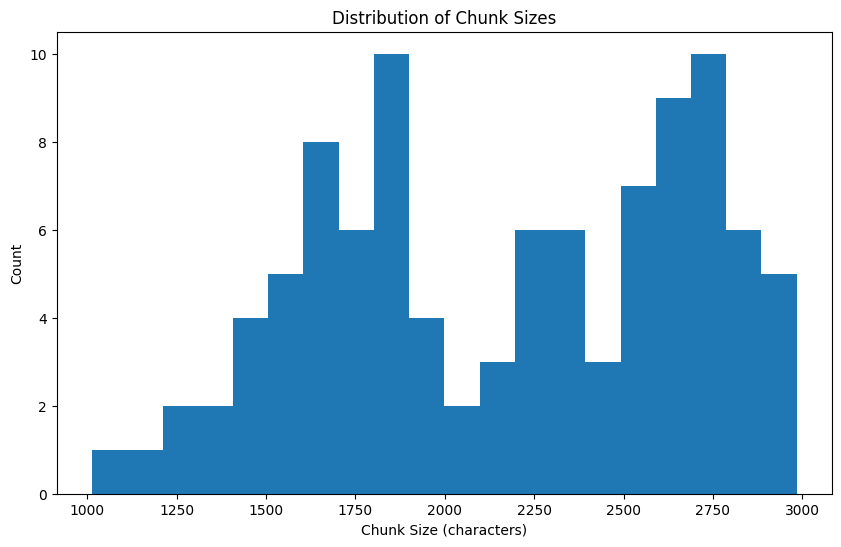


Chunk sizes look good!


In [16]:
# Cell 13: Analyze Current Chunk Sizes
print("Analyzing current chunk sizes...\n")

# Get a sample of chunks
sample = collection.get(limit=20)

chunk_lengths = [len(doc) for doc in sample['documents']]
print(f"Chunk size statistics:")
print(f"   Min: {min(chunk_lengths)} chars")
print(f"   Max: {max(chunk_lengths)} chars")
print(f"   Average: {sum(chunk_lengths)//len(chunk_lengths)} chars")
print(f"   Total chunks: {collection.count()}")

# Show distribution
print(f"\nSize distribution:")
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist([len(doc) for doc in collection.get(limit=100)['documents']], bins=20)
plt.xlabel('Chunk Size (characters)')
plt.ylabel('Count')
plt.title('Distribution of Chunk Sizes')
plt.show()

# Check if chunks are too small
small_chunks = [l for l in chunk_lengths if l < 500]
if len(small_chunks) > len(chunk_lengths) * 0.3:
    print("\n WARNING: Many chunks are small! Consider reprocessing with larger chunk_size.")
else:
    print("\nChunk sizes look good!")

In [17]:
def clear_database():
    """Clear all data from the database"""
    try:
        count_before = collection.count()
        if count_before == 0:
            print("  Database is already empty")
            return
            
        response = input(f" Delete all {count_before} chunks? Type 'YES' to confirm: ")
        if response == 'YES':
            # Get all IDs
            all_ids = collection.get()['ids']
            if all_ids:
                collection.delete(ids=all_ids)
                print(f" Deleted {count_before} chunks from collection")
            
            # Verify it's empty
            count_after = collection.count()
            print(f" Collection now has {count_after} chunks")
        else:
            print(" Operation cancelled")
    except Exception as e:
        print(f"Error clearing database: {e}")

# Test the function
#clear_database()

In [18]:
collection.peek()  # Or use collection.get() to see chunk IDs


{'ids': ['100_Report - Raj Kiran.pdf_chunk_0',
  '100_Report - Raj Kiran.pdf_chunk_1',
  '100_Report - Raj Kiran.pdf_chunk_2',
  '100_Report - Raj Kiran.pdf_chunk_3',
  '100_Report - Raj Kiran.pdf_chunk_4',
  '100_Report - Raj Kiran.pdf_chunk_5',
  '100_Report - Raj Kiran.pdf_chunk_6',
  '100_Report - Raj Kiran.pdf_chunk_7',
  '100_Report - Raj Kiran.pdf_chunk_8',
  '100_Report - Raj Kiran.pdf_chunk_9'],
 'embeddings': array([[-0.00563105,  0.0167183 , -0.01310646, ...,  0.00573733,
         -0.01237135, -0.02724457],
        [ 0.02623169, -0.00910875,  0.03407014, ...,  0.0274118 ,
         -0.00687096,  0.00705954],
        [ 0.01550307,  0.02868799, -0.00468095, ...,  0.02589978,
         -0.00010401, -0.01030831],
        ...,
        [-0.02059907,  0.01253679, -0.03398529, ...,  0.02452859,
         -0.00994088, -0.00088712],
        [-0.00190948,  0.02241377, -0.00857191, ...,  0.00472537,
         -0.0561363 , -0.00481184],
        [-0.00715812,  0.04823392, -0.01307459, ..., -0

In [19]:
print(f"📦 Total documents in collection: {collection.count()}")


📦 Total documents in collection: 3531


In [20]:
import inspect

print("📂 Collection name:", collection.name)
print("📦 Total documents:", collection.count())

# Inspect client object to confirm it's a PersistentClient
print("🧪 Client type:", type(chroma_client))

# Optional: Look into where it's storing (if PersistentClient)
print("📍 DB location :", inspect.getsourcefile(type(chroma_client)))


📂 Collection name: rag-chunks
📦 Total documents: 3531
🧪 Client type: <class 'chromadb.api.client.Client'>
📍 DB location : C:\Users\rohan\AppData\Roaming\Python\Python313\site-packages\chromadb\api\client.py


In [21]:
import os

# Get absolute path
abs_path = os.path.abspath("vector_db_july500")
print(f"Absolute path: {abs_path}")
print(f"Current working directory: {os.getcwd()}")

# Check if the directory exists and what's in it
if os.path.exists("vector_db_july500"):
    files = os.listdir("vector_db_july500")
    print(f"Files in vector_db_july500: {files}")

Absolute path: c:\Users\rohan\Desktop\chatbot\999\vector_db_july500
Current working directory: c:\Users\rohan\Desktop\chatbot\999
Files in vector_db_july500: ['bd1033ab-fc9a-4d61-9330-4d5e9d5db8fa', 'chroma.sqlite3']


In [22]:
import os

# Get absolute path
abs_path = os.path.abspath("vector_db_july500")
print(f"Absolute path: {abs_path}")
print(f"Current working directory: {os.getcwd()}")

# Check if the directory exists and what's in it
if os.path.exists("vector_db_july500"):
    files = os.listdir("vector_db_july500")
    print(f"Files in vector_db_july500: {files}")

Absolute path: c:\Users\rohan\Desktop\chatbot\999\vector_db_july500
Current working directory: c:\Users\rohan\Desktop\chatbot\999
Files in vector_db_july500: ['bd1033ab-fc9a-4d61-9330-4d5e9d5db8fa', 'chroma.sqlite3']
